**Steady-State Mass Constrained Neural Networks (MCNN)**

This code develops steady-state MCNN models for the cases when *no noise* or *constant bias with / without Gausssian noise* is added to true data to generate training data.

The unconstrained network model is trained first, followed by the constrained model, i.e., MCNN. 
The optimal solution of the unconstrained network serve as initial guesses for the constrained formulation of the inverse problem.

Load the training and validation / simulation datasets and specify the input and output variables for the NN models. Note that the user can consider any steady-state dataset for training and validation. The rows signify the observation indices for steady-state data and the columns signify the input and output variables.

In [1]:
import numpy as np
import scipy as sp
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from idaes.core.solvers import get_solver
get_solver()
import matplotlib.pyplot as plt
import pandas as pd
from pyDOE import *
import math as mt
import time
import json
import pickle

In [2]:
# Loading the data for model development

data = pd.read_excel("Steady-State CSTR Data.xlsx","NoNoise", header=None).values
# data = pd.read_excel("Steady-State CSTR Data.xlsx","ConstantBias+Gaussian Noise", header=None).values
data = data[2:, 1:]

# For this specific system, the first five columns are the model inputs and the following four columns are the model outputs

input_data = data[:,0:5]
output_data = data[:,5:]

ni = input_data.shape[1]         # Number of inputs = Number of neurons in input layer
no = output_data.shape[1]        # Number of outputs = Number of neurons in output layer

# Default number of neurons in hidden layer taken equal to number of neurons in input layer. But it can be changed as needed.

nh = ni

nt = ni + no                     # Total number of variables

n = data.shape[0]                # Total number of datasets available for model development

In [3]:
# Defining the System Model in terms of Process Variables

## Reaction Model: Cyclopentadiene (A, C5H6) reacts in water (aqueous) medium to form Cyclopentenol (B, C5H8O), which again gives 
## Cyclopentanediol (C, C5H10O2). Simultaneously, 2 moles of A combine to form Dicyclopentadiene (D, C10H12). C and D are undesirable products.
## Density changes in the reactor are assumed to be negligible.

# Number of C atoms in one model of each reaction species
ncA = 5; ncB = 5; ncC = 5; ncD = 10;

# Number of H atoms in one model of each reaction species (including water)
nhA = 6; nhB = 8; nhC = 10; nhD = 12; nhW = 2;

# Number of O atoms in one model of each reaction species (including water)
noA = 0; noB = 1; noC = 2; noD = 0; noW = 1;

# Density of each reaction species (in Kg/m3)
rhoA = 786; rhoB = 949; rhoC = 1094; rhoD = 980; rhoW = 997;

# Molecular Weight of each reaction species
MWA = 66; MWB = 90; MWC = 102; MWD = 132; MWW = 18;

V = 0.1                          # m3 (Volume of Reactor)

fv_in = data[:,0]
CAf_in = data[:,1]
CBf_in = data[:,2]
CCf_in = data[:,3]
CDf_in = data[:,4]
CA_out = data[:,5]
CB_out = data[:,6]
CC_out = data[:,7]
CD_out = data[:,8]

# Calculation of number of moles of water in inlet stream (kmol/min)
mol_W_in = (rhoW/MWW)*fv_in*V

# Calculation of number of moles of A,B,C,D in inlet stream (kmol/min)
mol_A_in = V*fv_in*CAf_in 
mol_B_in = V*fv_in*CBf_in
mol_C_in = V*fv_in*CCf_in 
mol_D_in = V*fv_in*CDf_in

# Total number of atoms of C and H in inlet stream
at_C_in = mol_A_in*ncA + mol_B_in*ncB + mol_C_in*ncC + mol_D_in*ncD
at_H_in = mol_A_in*nhA + mol_B_in*nhB + mol_C_in*nhC + mol_D_in*nhD + mol_W_in*nhW
at_O_in = mol_A_in*noA + mol_B_in*noB + mol_C_in*noC + mol_D_in*noD + mol_W_in*noW

In [4]:
# Data Preparation for Model Training

tn = int(0.7*n)                  # Selecting 70% of total data for training

# Normalization of model input and output variables
norm_mat = np.zeros((n, nt))
delta = np.zeros(nt)
for i in range(nt):
    delta[i] = np.max(data[:, i]) - np.min(data[:, i])
    norm_mat[:, i] = (data[:, i] - np.min(data[:, i])) / delta[i]  # Max-Min Normalization

Imat = norm_mat[:,0:ni].T
dsr = norm_mat[:,ni:nt].T

# Generating random training data for tn steps / indices
tr_steps = np.random.choice(n, tn, replace=False)
tr_steps = np.sort(tr_steps)

dsr_t = dsr[:, tr_steps-1]
Imat_t = Imat[:, tr_steps-1]
fv_in_t = fv_in[tr_steps-1]
CAf_in_t = CAf_in[tr_steps-1]
CBf_in_t = CBf_in[tr_steps-1]
CCf_in_t = CCf_in[tr_steps-1]
CDf_in_t = CDf_in[tr_steps-1]
at_C_in_t = at_C_in[tr_steps-1]
at_H_in_t = at_H_in[tr_steps-1]
at_O_in_t = at_O_in[tr_steps-1]
mol_W_in_t = mol_W_in[tr_steps-1]

**TRAINING (INVERSE PROBLEM) OF UNCONSTRAINED NEURAL NETWORKS** 

In [5]:
## Training of Unconstrained NN Model using Pyomo

## May use any NN library / package to train the unconstrained model

M = pyo.ConcreteModel()

M.I1 = pyo.RangeSet(1, ni)
M.I2 = pyo.RangeSet(1, nh)
M.I3 = pyo.RangeSet(1, no)
M.I4 = pyo.RangeSet(1, tn)

M.x1 = pyo.Var(M.I1,M.I2, bounds = (-0.5e1,0.5e1), initialize = 1e-1)                   # w_h (ANN)
M.x2 = pyo.Var(M.I2, bounds = (-0.5e1,0.5e1), initialize = 1e-1)                        # b_h (ANN)
M.x3 = pyo.Var(M.I2,M.I3,bounds = (-0.5e1,0.5e1), initialize = 1e-1)                    # w_o (ANN)
M.x4 = pyo.Var(M.I3, bounds = (-0.5e1,0.5e1), initialize = 1e-1)                        # b_o (ANN)

M.y1 = pyo.Var(M.I2,M.I4)                     # y_h (ANN)
M.y2 = pyo.Var(M.I3,M.I4)                     # y_ANN

def constraint_rule_1(M,i,j):
    return M.y1[i,j] == 1/(1 + pyo.exp(-sum((M.x1[k,i] * Imat_t[k-1,j-1]) for k in M.I1) + M.x2[i]))

M.constraint_1 = pyo.Constraint(M.I2, M.I4, rule = constraint_rule_1)         
    
def constraint_rule_2(M,i,j):
    return M.y2[i,j] == sum((M.x3[k,i] * M.y1[k,j]) for k in M.I2) + M.x4[i]

M.constraint_2 = pyo.Constraint(M.I3, M.I4, rule = constraint_rule_2)

def NN_unc_Obj(M):             
    obj_value = sum(sum((dsr_t[i-1,j-1] - M.y2[i,j]) ** 2 for i in M.I3) for j in M.I4)
    return obj_value

M.obj = pyo.Objective(rule = NN_unc_Obj, sense = pyo.minimize)

solver = pyo.SolverFactory('ipopt')
solver.options['max_iter'] = 1000

results = solver.solve(M, tee=True)

Ipopt 3.13.2: max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computatio

In [6]:
## Accessing the optimal parameters of Unconstrained NN Model

w_h = np.zeros((ni,nh))
for (i,j) in M.x1:
    w_h[i-1,j-1] = pyo.value(M.x1[i,j])

b_h = np.zeros(nh)
for i in M.x2:
    b_h[i-1] = pyo.value(M.x2[i])

w_o = np.zeros((nh,no))
for (i,j) in M.x3:
    w_o[i-1,j-1] = pyo.value(M.x3[i,j])

b_o = np.zeros(no)
for i in M.x4:
    b_o[i-1] = pyo.value(M.x4[i])

y_h_nn_wo = np.zeros((nh,tn))
for (i,j) in M.y1:
    y_h_nn_wo[i-1,j-1] = pyo.value(M.y1[i,j])

ynn_wo = np.zeros((no,tn))
for (i,j) in M.y2:
    ynn_wo[i-1,j-1] = pyo.value(M.y2[i,j])

In [7]:
## Calculating mass balance errors from unconstrained NN Model

ynn_wo_t_p = np.zeros((tn,no))
dsr_t_p = np.zeros((tn,no))

for i in range(no):
    ynn_wo_t_p[:,i] = ynn_wo[i,:].T*delta[ni+i] + np.min(data[:,ni+i])
    dsr_t_p[:,i] = dsr_t[i,:].T*delta[ni+i] + np.min(data[:,ni+i])

CA_NN_out_womc = ynn_wo_t_p[:,0]
CB_NN_out_womc = ynn_wo_t_p[:,1]
CC_NN_out_womc = ynn_wo_t_p[:,2]
CD_NN_out_womc = ynn_wo_t_p[:,3]

# Calculation of number of moles of water in outlet stream (kmol/min)
mol_AtoB = fv_in_t*V*(CAf_in_t - CA_NN_out_womc - 2*(CD_NN_out_womc - CDf_in_t))
C_Bformed = CAf_in_t - CA_NN_out_womc - 2*(CD_NN_out_womc - CDf_in_t)
mol_BtoC = fv_in_t*V*(CBf_in_t + C_Bformed - CB_NN_out_womc)
mol_W_out_t_womc = mol_W_in_t - (mol_AtoB + mol_BtoC)

# Calculation of number of moles of A,B,C,D in outlet stream (kmol/min)
mol_A_out_t_womc = V*fv_in_t*CA_NN_out_womc 
mol_B_out_t_womc = V*fv_in_t*CB_NN_out_womc
mol_C_out_t_womc = V*fv_in_t*CC_NN_out_womc 
mol_D_out_t_womc = V*fv_in_t*CD_NN_out_womc

# Total number of atoms of C and H in outlet stream
at_C_out_t_womc = mol_A_out_t_womc*ncA + mol_B_out_t_womc*ncB + mol_C_out_t_womc*ncC + mol_D_out_t_womc*ncD
at_H_out_t_womc = mol_A_out_t_womc*nhA + mol_B_out_t_womc*nhB + mol_C_out_t_womc*nhC + mol_D_out_t_womc*nhD + mol_W_out_t_womc*nhW
at_O_out_t_womc = mol_A_out_t_womc*noA + mol_B_out_t_womc*noB + mol_C_out_t_womc*noC + mol_D_out_t_womc*noD + mol_W_out_t_womc*noW

# Error in Mass Balance Calculations

diff_t_womc = 100*np.abs(np.array([np.divide(at_C_in_t - at_C_out_t_womc,at_C_in_t), np.divide(at_H_in_t - at_H_out_t_womc,at_H_in_t), \
                                   np.divide(at_O_in_t - at_O_out_t_womc,at_O_in_t)]))

# Saving the optimal weights and biases to use as initial guess for the constrained NN Models

whf_womc_opt = w_h
wof_womc_opt = w_o
bhf_womc_opt = b_h
bof_womc_opt = b_o
ynn_womc_opt = ynn_wo_t_p.T

**TRAINING (INVERSE PROBLEM) OF CONSTRAINED NEURAL NETWORKS (MCNN)** 

In [8]:
## Training the Constrained NN Model, i.e., MCNN using Pyomo

M1 = pyo.ConcreteModel()

M1.I1 = pyo.RangeSet(1, ni)
M1.I2 = pyo.RangeSet(1, nh)
M1.I3 = pyo.RangeSet(1, no)
M1.I4 = pyo.RangeSet(1, tn)

M1.x1 = pyo.Var(M1.I1,M1.I2, bounds = (-0.5e1,0.5e1))                   # w_h (NN)
for i,j in M1.x1:
    M1.x1[i, j] = whf_womc_opt[i-1, j-1]

M1.x2 = pyo.Var(M1.I2, bounds = (-0.5e1,0.5e1))                        # b_h (NN)
for i in M1.x2:
    M1.x2[i] = bhf_womc_opt[i-1]

M1.x3 = pyo.Var(M1.I2,M1.I3, bounds = (-0.5e1,0.5e1))                   # w_o (NN)
for i,j in M1.x3:
    M1.x3[i, j] = wof_womc_opt[i-1, j-1]

M1.x4 = pyo.Var(M1.I3, bounds = (-0.5e1,0.5e1))                        # b_o (NN)
for i in M1.x4:
    M1.x4[i] = bof_womc_opt[i-1]

M1.x5 = pyo.Var(M1.I3,M1.I4, bounds = (1e-5,1e5))                  # y_ddr (MCNN)
for i,j in M1.x5:
    M1.x5[i, j] = ynn_womc_opt[i-1, j-1]    

M1.y1 = pyo.Var(M1.I2,M1.I4)                     # y_h (NN)
for i,j in M1.y1:
    M1.y1[i, j] = y_h_nn_wo[i-1, j-1]

M1.y2 = pyo.Var(M1.I3,M1.I4)                     # y_NN_norm
for i,j in M1.y2:
    M1.y2[i, j] = ynn_wo[i-1, j-1]

M1.y3 = pyo.Var(M1.I3,M1.I4)                     # y_NN_unnorm
for i,j in M1.y3:
    M1.y3[i, j] = ynn_womc_opt[i-1, j-1]

def constraint_rule_1(M1,i,j):
    return M1.y1[i,j] == 1/(1 + pyo.exp(-sum((M1.x1[k,i] * Imat_t[k-1,j-1]) for k in M1.I1) + M1.x2[i]))

M1.constraint_1 = pyo.Constraint(M1.I2, M1.I4, rule = constraint_rule_1)         
    
def constraint_rule_2(M1,i,j):
    return M1.y2[i,j] == sum((M1.x3[k,i] * M1.y1[k,j]) for k in M1.I2) + M1.x4[i]

M1.constraint_2 = pyo.Constraint(M1.I3, M1.I4, rule = constraint_rule_2)

# Scaling - Unscaling Constraint

def constraint_rule_3(M1,i,j):
    return M1.y3[i,j] == M1.y2[i,j]*delta[ni+i] + pyo.min(data[:,ni+i])

# The mass balance constraints for each C, H, and O atoms in this example all boil down to the form: CA + CB + CC + 2*CD = CAf + CBf + CCf + 2*CDf
# Therefore, instead of all calculations shown above for calculating the moles of atoms in the outlet stream, this algebraic simplification is posed 
# as the equality constraint, with respect to M.x5.

# Defining the mass constraints

def constraint_rule_4(M1,j):
    return M1.x5[1,j] + M1.x5[2,j] + M1.x5[3,j] + 2*M1.x5[4,j] == CAf_in_t[j-1] + CBf_in_t[j-1] + CCf_in_t[j-1] + 2*CDf_in_t[j-1]

M1.constraint_4 = pyo.Constraint(M1.I4, rule = constraint_rule_4)

def MCNN_con_Obj(M1):             
    obj_value = sum(sum((dsr_t_p[j-1,i-1] - M1.x5[i,j]) ** 2 for i in M1.I3) for j in M1.I4) + \
                sum(sum((M1.x5[i,j] - M1.y3[i,j]) ** 2 for i in M1.I3) for j in M1.I4)
    return obj_value

M1.obj = pyo.Objective(rule = MCNN_con_Obj, sense = pyo.minimize)

solver = pyo.SolverFactory('ipopt')
solver.options['max_iter'] = 1000

results = solver.solve(M1, tee=True)

Ipopt 3.13.2: max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computatio

In [9]:
## Accessing the optimal parameters of MCNN Model

w_h_mcnn = np.zeros((ni,nh))
for (i,j) in M1.x1:
    w_h_mcnn[i-1,j-1] = pyo.value(M1.x1[i,j])

b_h_mcnn = np.zeros(nh)
for i in M1.x2:
    b_h_mcnn[i-1] = pyo.value(M1.x2[i])

w_o_mcnn = np.zeros((nh,no))
for (i,j) in M1.x3:
    w_o_mcnn[i-1,j-1] = pyo.value(M1.x3[i,j])

b_o_mcnn = np.zeros(no)
for i in M1.x4:
    b_o_mcnn[i-1] = pyo.value(M1.x4[i])

ynn_mcnn = np.zeros((no,tn))
for (i,j) in M1.x5:
    ynn_mcnn[i-1,j-1] = pyo.value(M1.x5[i,j])

In [10]:
## Calculating mass balance errors from MCNN Model

ynn_mcnn_t_p = ynn_mcnn.T

CA_NN_out_mcnn = ynn_mcnn_t_p[:,0]
CB_NN_out_mcnn = ynn_mcnn_t_p[:,1]
CC_NN_out_mcnn = ynn_mcnn_t_p[:,2]
CD_NN_out_mcnn = ynn_mcnn_t_p[:,3]

# Calculation of number of moles of water in outlet stream (kmol/min)
mol_AtoB = fv_in_t*V*(CAf_in_t - CA_NN_out_mcnn - 2*(CD_NN_out_mcnn - CDf_in_t))
C_Bformed = CAf_in_t - CA_NN_out_mcnn - 2*(CD_NN_out_mcnn - CDf_in_t)
mol_BtoC = fv_in_t*V*(CBf_in_t + C_Bformed - CB_NN_out_mcnn)
mol_W_out_t_mcnn = mol_W_in_t - (mol_AtoB + mol_BtoC)

# Calculation of number of moles of A,B,C,D in outlet stream (kmol/min)
mol_A_out_t_mcnn = V*fv_in_t*CA_NN_out_mcnn 
mol_B_out_t_mcnn = V*fv_in_t*CB_NN_out_mcnn
mol_C_out_t_mcnn = V*fv_in_t*CC_NN_out_mcnn 
mol_D_out_t_mcnn = V*fv_in_t*CD_NN_out_mcnn

# Total number of atoms of C and H in outlet stream
at_C_out_t_mcnn = mol_A_out_t_mcnn*ncA + mol_B_out_t_mcnn*ncB + mol_C_out_t_mcnn*ncC + mol_D_out_t_mcnn*ncD
at_H_out_t_mcnn = mol_A_out_t_mcnn*nhA + mol_B_out_t_mcnn*nhB + mol_C_out_t_mcnn*nhC + mol_D_out_t_mcnn*nhD + mol_W_out_t_mcnn*nhW
at_O_out_t_mcnn = mol_A_out_t_mcnn*noA + mol_B_out_t_mcnn*noB + mol_C_out_t_mcnn*noC + mol_D_out_t_mcnn*noD + mol_W_out_t_mcnn*noW

# Error in Mass Balance Calculations

diff_t_mcnn = 100*np.abs(np.array([np.divide(at_C_in_t - at_C_out_t_mcnn,at_C_in_t), np.divide(at_H_in_t - at_H_out_t_mcnn,at_H_in_t), \
                                   np.divide(at_O_in_t - at_O_out_t_mcnn,at_O_in_t)]))

**END OF MODEL TRAINING**

In [11]:
## Data Preparation for Model Validation / Simulation

flag = 1
tv = n - tn
val_steps = []

for i in range(n):
    check = np.in1d(i,tr_steps)
    if check == [False]:
        val_steps.append(i)
        flag += 1

val_steps = np.sort(val_steps)

dsr_v = dsr[:, val_steps-1]
Imat_v = Imat[:, val_steps-1]
fv_in_v = fv_in[val_steps-1]
CAf_in_v = CAf_in[val_steps-1]
CBf_in_v = CBf_in[val_steps-1]
CCf_in_v = CCf_in[val_steps-1]
CDf_in_v = CDf_in[val_steps-1]
at_C_in_v = at_C_in[val_steps-1]
at_H_in_v = at_H_in[val_steps-1]
at_O_in_v = at_O_in[val_steps-1]
mol_W_in_v = mol_W_in[val_steps-1]

**VALIDATION / SIMULATION OF UNCONSTRAINED NETWORK MODEL (FORWARD PROBLEM)**

In [12]:
# Validation of the optimal unconstrained model
y1 = np.zeros((nh,tv))
y2 = np.zeros((no,tv))
        
for i in range(nh):
    for j in range(tv):
        summ = 0
        for k in range(ni):
            summ += (whf_womc_opt[k,i] * Imat_v[k-1,j-1]) 

        y1[i,j] = 1/(1 + pyo.exp(-summ + bhf_womc_opt[i]))

for i in range(no):
    for j in range(tv):
        summ = 0
        for k in range(nh):
            summ += (wof_womc_opt[k,i] * y1[k,j]) 

        y2[i,j] = summ + bof_womc_opt[i]

ynn_wo_v = y2

In [13]:
## Calculating mass balance errors from unconstrained NN Model for Validation data

ynn_wo_v_p = np.zeros((tv,no))
dsr_v_p = np.zeros((tv,no))

for i in range(no):
    ynn_wo_v_p[:,i] = ynn_wo_v[i,:].T*delta[ni+i] + np.min(data[:,ni+i])
    dsr_v_p[:,i] = dsr_v[i,:].T*delta[ni+i] + np.min(data[:,ni+i])

CA_NN_out_v_womc = ynn_wo_v_p[:,0]
CB_NN_out_v_womc = ynn_wo_v_p[:,1]
CC_NN_out_v_womc = ynn_wo_v_p[:,2]
CD_NN_out_v_womc = ynn_wo_v_p[:,3]

# Calculation of number of moles of water in outlet stream (kmol/min)
mol_AtoB = fv_in_v*V*(CAf_in_v - CA_NN_out_v_womc - 2*(CD_NN_out_v_womc - CDf_in_v))
C_Bformed = CAf_in_v - CA_NN_out_v_womc - 2*(CD_NN_out_v_womc - CDf_in_v)
mol_BtoC = fv_in_v*V*(CBf_in_v + C_Bformed - CB_NN_out_v_womc)
mol_W_out_v_womc = mol_W_in_v - (mol_AtoB + mol_BtoC)

# Calculation of number of moles of A,B,C,D in outlet stream (kmol/min)
mol_A_out_v_womc = V*fv_in_v*CA_NN_out_v_womc 
mol_B_out_v_womc = V*fv_in_v*CB_NN_out_v_womc
mol_C_out_v_womc = V*fv_in_v*CC_NN_out_v_womc 
mol_D_out_v_womc = V*fv_in_v*CD_NN_out_v_womc

# Total number of atoms of C and H in outlet stream
at_C_out_v_womc = mol_A_out_v_womc*ncA + mol_B_out_v_womc*ncB + mol_C_out_v_womc*ncC + mol_D_out_v_womc*ncD
at_H_out_v_womc = mol_A_out_v_womc*nhA + mol_B_out_v_womc*nhB + mol_C_out_v_womc*nhC + mol_D_out_v_womc*nhD + mol_W_out_v_womc*nhW
at_O_out_v_womc = mol_A_out_v_womc*noA + mol_B_out_v_womc*noB + mol_C_out_v_womc*noC + mol_D_out_v_womc*noD + mol_W_out_v_womc*noW

# Error in Mass Balance Calculations

diff_v_womc = 100*np.abs(np.array([np.divide(at_C_in_v - at_C_out_v_womc,at_C_in_v), np.divide(at_H_in_v - at_H_out_v_womc,at_H_in_v), \
                                   np.divide(at_O_in_v - at_O_out_v_womc,at_O_in_v)]))

**VALIDATION / SIMULATION OF CONSTRAINED NETWORK (MCNN) MODEL (FORWARD PROBLEM)**

In [14]:
# Validation of the optimal constrained model
y1_mcnn = np.zeros((nh,tv))
y2_mcnn = np.zeros((no,tv))
        
for i in range(nh):
    for j in range(tv):
        summ = 0
        for k in range(ni):
            summ += (w_h_mcnn[k,i] * Imat_v[k-1,j-1]) 

        y1_mcnn[i,j] = 1/(1 + pyo.exp(-summ + b_h_mcnn[i]))

for i in range(no):
    for j in range(tv):
        summ = 0
        for k in range(nh):
            summ += (w_o_mcnn[k,i] * y1_mcnn[k,j]) 

        y2_mcnn[i,j] = summ + b_o_mcnn[i]

ynn_v = y2_mcnn

ynn_v_p = np.zeros((tv,no))

for i in range(no):
    ynn_v_p[:,i] = ynn_v[i,:].T*delta[ni+i] + min(data[:,ni+i])

ynn_v_unnorm = ynn_v_p.T

In [25]:
# Dynamic Data Reconciliation Post Processing Step during Model Validation

MV = pyo.ConcreteModel()

MV.I1 = pyo.RangeSet(1, no)
MV.I2 = pyo.RangeSet(1, tv)

MV.x1 = pyo.Var(MV.I1,MV.I2, bounds = (1e-5,1e5))                   # ynn_val_ddr
for i,j in MV.x1:
    MV.x1[i, j] = dsr_v_p.T[i-1, j-1]

# Defining the mass constraints

def constraint_rule_1(MV,j):
    return MV.x1[1,j] + MV.x1[2,j] + MV.x1[3,j] + 2*MV.x1[4,j] == CAf_in_v[j-1] + CBf_in_v[j-1] + CCf_in_v[j-1] + 2*CDf_in_v[j-1]
    
MV.constraint_1 = pyo.Constraint(MV.I2, rule = constraint_rule_1)         
    
def MCNN_Val_Obj(MV):             
    obj_value = sum(sum((ynn_v_unnorm[i-1,j-1] - MV.x1[i,j]) ** 2 for i in MV.I1) for j in MV.I2)
    return obj_value

MV.obj = pyo.Objective(rule = MCNN_Val_Obj, sense = pyo.minimize)

solver = pyo.SolverFactory('ipopt')
solver.options['max_iter'] = 1000

results = solver.solve(M, tee=True)

Ipopt 3.13.2: max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computatio

In [26]:
# Accessing Validation Results from MCNN

ynn_mcnn_val = np.zeros((no,tv))
for (i,j) in MV.x1:
    ynn_mcnn_val[i-1,j-1] = pyo.value(MV.x1[i,j])

ynn_mcnn_v_p = ynn_mcnn_val.T

In [27]:
## Calculating mass balance errors from MCNN Model during Validation (Forward Problem)

CA_NN_out_v_mcnn = ynn_mcnn_v_p[:,0]
CB_NN_out_v_mcnn = ynn_mcnn_v_p[:,1]
CC_NN_out_v_mcnn = ynn_mcnn_v_p[:,2]
CD_NN_out_v_mcnn = ynn_mcnn_v_p[:,3]

# Calculation of number of moles of water in outlet stream (kmol/min)
mol_AtoB = fv_in_v*V*(CAf_in_v - CA_NN_out_v_mcnn - 2*(CD_NN_out_v_mcnn - CDf_in_v))
C_Bformed = CAf_in_v - CA_NN_out_v_mcnn - 2*(CD_NN_out_v_mcnn - CDf_in_v)
mol_BtoC = fv_in_v*V*(CBf_in_v + C_Bformed - CB_NN_out_v_mcnn)
mol_W_out_v_mcnn = mol_W_in_v - (mol_AtoB + mol_BtoC)

# Calculation of number of moles of A,B,C,D in outlet stream (kmol/min)
mol_A_out_v_mcnn = V*fv_in_v*CA_NN_out_v_mcnn 
mol_B_out_v_mcnn = V*fv_in_v*CB_NN_out_v_mcnn
mol_C_out_v_mcnn = V*fv_in_v*CC_NN_out_v_mcnn 
mol_D_out_v_mcnn = V*fv_in_v*CD_NN_out_v_mcnn

# Total number of atoms of C and H in outlet stream
at_C_out_v_mcnn = mol_A_out_v_mcnn*ncA + mol_B_out_v_mcnn*ncB + mol_C_out_v_mcnn*ncC + mol_D_out_v_mcnn*ncD
at_H_out_v_mcnn = mol_A_out_v_mcnn*nhA + mol_B_out_v_mcnn*nhB + mol_C_out_v_mcnn*nhC + mol_D_out_v_mcnn*nhD + mol_W_out_v_mcnn*nhW
at_O_out_v_mcnn = mol_A_out_v_mcnn*noA + mol_B_out_v_mcnn*noB + mol_C_out_v_mcnn*noC + mol_D_out_v_mcnn*noD + mol_W_out_v_mcnn*noW

# Error in Mass Balance Calculations

diff_v_mcnn = 100*np.abs(np.array([np.divide(at_C_in_v - at_C_out_v_mcnn,at_C_in_v), np.divide(at_H_in_v - at_H_out_v_mcnn,at_H_in_v), \
                                   np.divide(at_O_in_v - at_O_out_v_mcnn,at_O_in_v)]))

**PLOTTING TRAINING RESULTS**

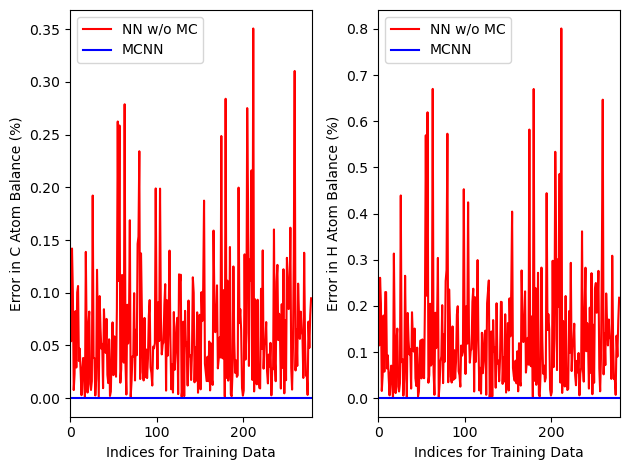

In [24]:
plt.subplot(1,2,1)
plt.plot(diff_t_womc[1,:], color = 'red', linewidth = 1.5, label = 'NN w/o MC')
plt.plot(diff_t_mcnn[1,:], color = 'blue', linewidth = 1.5, label = 'MCNN')
plt.xlim(0, tn)
plt.xlabel('Indices for Training Data')
plt.ylabel('Error in C Atom Balance (%)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(diff_t_womc[2,:], color = 'red', linewidth = 1.5, label = 'NN w/o MC')
plt.plot(diff_t_mcnn[2,:], color = 'blue', linewidth = 1.5, label = 'MCNN')
plt.xlim(0, tn)
plt.xlabel('Indices for Training Data')
plt.ylabel('Error in H Atom Balance (%)')
plt.legend()

plt.tight_layout()
plt.show()

**PLOTTING VALIDATION / SIMULATION RESULTS**

In [33]:
plt.subplot(1,2,1)
plt.plot(diff_v_womc[1,:], color = 'red', linewidth = 1.5, label = 'NN w/o MC')
plt.plot(diff_v_mcnn[1,:], color = 'blue', linewidth = 1.5, label = 'MCNN')
plt.xlim(0, tv)
plt.xlabel('Indices for Validation Data')
plt.ylabel('Error in C Atom Balance (%)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(diff_v_womc[2,:], color = 'red', linewidth = 1.5, label = 'NN w/o MC')
plt.plot(diff_v_mcnn[2,:], color = 'blue', linewidth = 1.5, label = 'MCNN')
plt.xlim(0, tv)
plt.xlabel('Indices for Validation Data')
plt.ylabel('Error in H Atom Balance (%)')
plt.legend()

plt.tight_layout()
plt.show()